In [ ]:
import tensorflow as tf
import numpy
import scipy.io
#from tensorflow.python.client import timeline
import time

percorsoDati = "/home/protoss/hanford.mat"

struttura = scipy.io.loadmat(percorsoDati)['hanford']

peakmap = struttura[9002].copy()

del struttura
peakmap = peakmap[:,25:80]
from matplotlib import pyplot
%matplotlib notebook
pyplot.figure(figsize=(10, 8))
#a = pyplot.scatter(numpy.arange(tempiUnici.size),tempiUnici/30, s = 0.5)
a = pyplot.imshow(peakmap, origin = 'lower', interpolation = 'none')

<IPython.core.display.Javascript object>


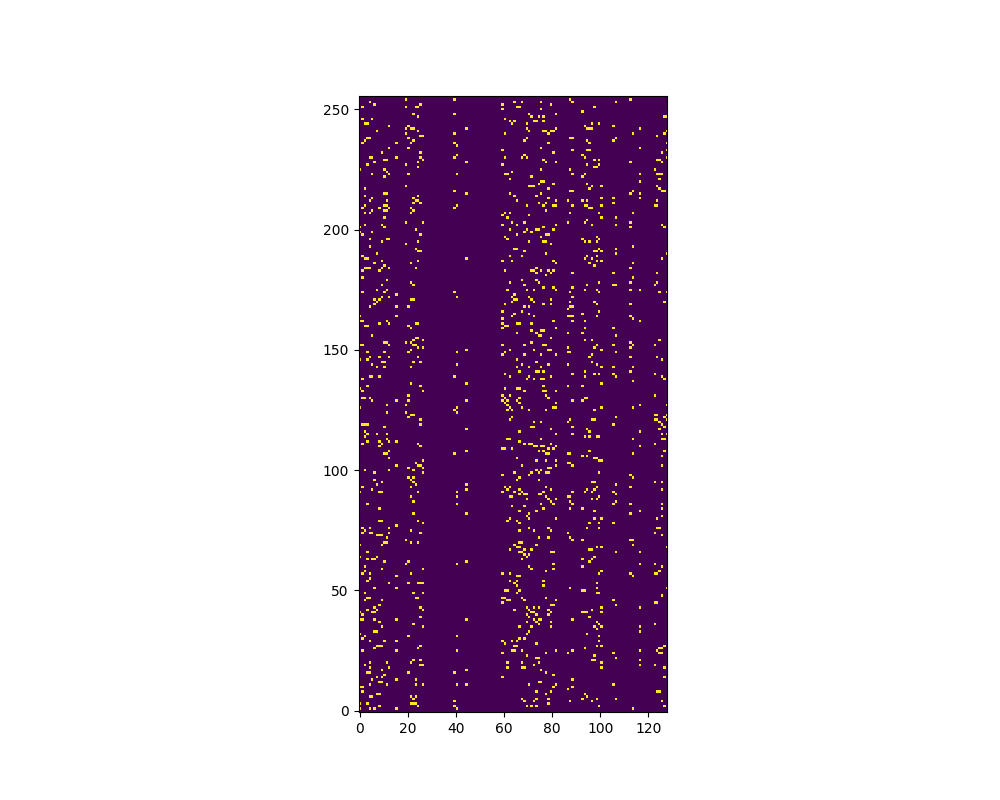

In [20]:
import tensorflow as tf
import numpy
import scipy.io
#from tensorflow.python.client import timeline
import time

percorsoDati = "/home/protoss/datiFederico2.mat"
#index = 9002 #signal
index = 4 #signal meno bello
#index = 5001

struttura1 = scipy.io.loadmat(percorsoDati)['H']
peakmap1 = struttura1[index].copy()
del struttura1

#struttura2 = scipy.io.loadmat(percorsoDati)['L']
#peakmap2 = struttura2[index].copy()
#del struttura2

#struttura3 = scipy.io.loadmat(percorsoDati)['V']
#peakmap3 = struttura3[index].copy()
#del struttura3

peakmapTOT = peakmap1#+peakmap2+peakmap3




#peakmap = peakmapTOT[:,25:80]
peakmap = peakmapTOT
from matplotlib import pyplot
%matplotlib notebook
pyplot.figure(figsize=(10, 8))
#a = pyplot.scatter(numpy.arange(tempiUnici.size),tempiUnici/30, s = 0.5)
a = pyplot.imshow(peakmap, origin = 'lower', interpolation = 'none')

In [21]:
#peakmap = struttura[0]

sparsa = numpy.nonzero(peakmap)

frequenze,tempi = sparsa
tempi = tempi+1
frequenze = frequenze / 8192 + 1
pesi = numpy.ones(sparsa[0].size)

tFft = 8192
#tFft = 4096
tObs = 1/4 #mesi
tObs = tObs*30*24*60*60

#headers vari
securbelt = 15000


#frequenze
#frequenze
stepFrequenza = 1/tFft
enhancement = 10
stepFreqRaffinato =  stepFrequenza/enhancement

freqMin = numpy.amin(frequenze)
freqMax = numpy.amax(frequenze)
freqIniz = freqMin- stepFrequenza/2 - stepFreqRaffinato
freqFin = freqMax + stepFrequenza/2 + stepFreqRaffinato
nstepFrequenze = numpy.ceil((freqFin-freqIniz)/stepFreqRaffinato)+securbelt

#tempi
#epoca definita come mediana di tempi di tutto il run
#epoca = (57722+57990)/2 #0
epoca = 30

#spindowns
spindownMin = -1e-8
spindownMax = 1e-10


nstepSpindown = 500#numpy.round((spindownMax-spindownMin)/stepSpindown).astype(numpy.int32)


stepSpindown = (spindownMax-spindownMin)/nstepSpindown#stepFrequenza/tObs 
print(stepSpindown)

# riarrangio gli array in modo che abbia i dati 
# nel formato che voglio io
frequenze = frequenze-freqIniz
frequenze = (frequenze/stepFreqRaffinato)-round(enhancement/2+0.001)

tempi = tempi-epoca
tempi = ((tempi)*3600*24/stepFreqRaffinato)
#tempi = numpy.round(tempi/1e8)*1e8

spindowns = numpy.arange(0, nstepSpindown)
spindowns = numpy.multiply(spindowns,stepSpindown)
spindowns = numpy.add(spindowns, spindownMin)
# così ho i tre array delle tre grandezze, 
#più i pesi e la fascia di sicurezza
indice0 = numpy.where(spindowns>0)[0]-1
print(indice0)
#spindowns = spindowns-spindowns[indice0]


2.02e-11
[495 496 497 498]


In [22]:


def mapnonVar(stepIesimo):
    sdTimed = tf.multiply(spindownsTF[stepIesimo], tempiTF, name = "Tdotpert")
    #sdTimed = tf.cast(sdTimed, dtype=tf.float32)
    
    appoggio = tf.round(frequenzeTF-sdTimed+securbeltTF/2, name = "appoggioperindici")
    appoggio = tf.cast(appoggio, dtype=tf.int64)
    
    valori = tf.unsorted_segment_sum(pesiTF, appoggio, nColumns)

#    zeriDopo = tf.zeros([nColumns - tf.size(valori)], dtype=tf.float32)    
#    riga = tf.concat([valori,zeriDopo],0, name = "rigadihough")
    return valori


#ora uso Tensorflow
securbeltTF = tf.constant(securbelt,dtype=tf.float64)
tempiTF = tf.constant(tempi,dtype=tf.float64)
pesiTF = tf.constant(pesi,dtype=tf.float64)
spindownsTF = tf.constant(spindowns, dtype=tf.float64)
frequenzeTF = tf.constant(frequenze, dtype=tf.float64)

nRowsTF = tf.constant(nstepSpindown, dtype=tf.int64)
nColumns = nstepFrequenze

pesiTF = tf.reshape(pesiTF,(1,tf.size(pesi)))
pesiTF = pesiTF[0]

imagenonVar = tf.map_fn(mapnonVar, tf.range(0, nRowsTF), dtype=tf.float64, parallel_iterations=4)

#sessione = tf.Session(config=tf.ConfigProto(log_device_placement=True))
sessione = tf.Session()

#run_options = tf.RunOptions(trace_level=tf.RunOptions.FULL_TRACE)
#run_metadata = tf.RunMetadata()

start = time.time()
#image = sessione.run(imagenonVar, options=run_options, run_metadata=run_metadata)
image = sessione.run(imagenonVar)
stop = time.time()
print(stop-start)


    # Create the Timeline object, and write it to a json
#tl = timeline.Timeline(run_metadata.step_stats)
#ctf = tl.generate_chrome_trace_format()
#with open('timelinenonVar.json', 'w') as f:
#	f.write(ctf)

nColumns = nColumns.astype(int)
semiLarghezza = numpy.round(enhancement/2+0.001).astype(int)
image[:,semiLarghezza*2:nColumns]=image[:,semiLarghezza*2:nColumns]-image[:,0:nColumns - semiLarghezza*2]
image = numpy.cumsum(image, axis = 1)

0.06839323043823242


<IPython.core.display.Javascript object>


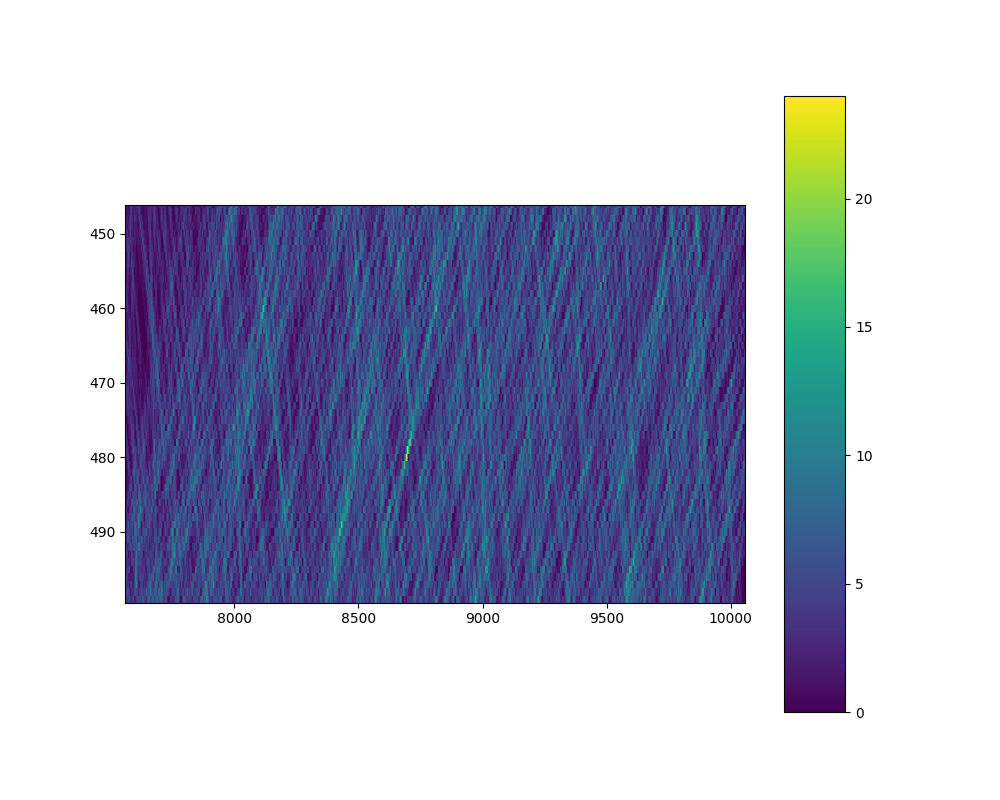

In [23]:
from matplotlib import pyplot
%matplotlib notebook
pyplot.figure(figsize=(10, 8))
a = pyplot.imshow(image, aspect = 30, interpolation = 'none')
#a = pyplot.imshow(image[94:98], aspect = 10000)
pyplot.colorbar(shrink = 1,aspect = 10)
#a = pyplot.imshow(image[191:192], aspect = 10000)
pyplot.show()
#
#DA METTER IN LOG

In [6]:
indice = 8050
freq = (indice-securbelt/2)/10
print(freq)

55.0


In [119]:
primaFreq = freqIniz-(securbelt/2)*stepFreqRaffinato

#freqIniziale = struttura['basic_info'][0,0]['frin'][0,0][0,0]
#freqFinale = struttura['basic_info'][0,0]['frfi'][0,0][0,0]
freqIniziale = freqIniz
freqFinale = freqFin
#QUI ANALOGO FUNZIONE CUT GD2
#%time indexInizialewh = numpy.where(freqniu>freqIniziale)[0][0]
#%time indexFinalewh = numpy.where(freqniu>freqFinale)[0][0]
start = time.time()

indexIniziale = ((freqIniziale-primaFreq)/stepFreqRaffinato).astype(numpy.int64)
indexFinale = ((freqFinale-primaFreq)/stepFreqRaffinato+1).astype(numpy.int64)

imageCand = image[:,indexIniziale:indexFinale]

size = numpy.shape(imageCand)[1]
freqniu = numpy.arange(0,size)*stepFreqRaffinato+freqIniziale


IndexError: index 48000 is out of bounds for axis 0 with size 2533